In [1]:
import mouseQPCRModelSelection 
import numpy as np
import time
import AssignGPGibbsSingleLoop
import GPflow
import numpy as np
import time
import cPickle as pickle
import assigngp_dense
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
GPflow.__version__

'0.1.3'

In [3]:
Bpossible = np.linspace(2,70,3)
pt,Yall = mouseQPCRModelSelection.LoadMouseQPCRData(subsetSelection=1)
Y = Yall[:,0][None].T
print 'Y'
print Y.shape
strExp = 'MouseQPCR_Exp1'
m,mV = mouseQPCRModelSelection.InitModels(pt,Y)

Loaded data data/guo_ssData.p with nrowsXncols = (437, 2).
(437, 2)
(437,)
LoadMouseQPCRData output
(437, 2)
(437,)
Y
(437, 1)
Branching kernel =====================
unnamed.branchkernelparam.\u001bBv\u001b transform:(none) prior:None
[[ 1.]]
unnamed.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
unnamed.white.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
Initialise models: MAP =====================
model.kern.branchkernelparam.\u001bBv\u001b transform:(none) prior:None
[[ 1.]]
model.kern.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.kern.white.\u001bvariance\u001b transform:+ve prior:None [FIXED]
[  1.00000000e-06]

model.likelihood.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
Initialise models: VB =====================
compiling tensor

In [4]:
Bpossible=None
strSaveState='test'
fSoftVBAssignment=False
fOptimizeHyperparameters = False
fReestimateMAPZ=False
numMAPsteps = 10
D=Y.shape[1]
print D

1


In [5]:
# Do the MAP solution and plot assignments
t0 = time.time()

Kbranch = m.kern
pt = mV.t
b = 10

Bcrap = np.atleast_2d(b) # crappy branch point

# reinitialise hyperparameters
Kbranch.white.variance = 1e-6
Kbranch.branchkernelparam.kern.lengthscales = 100 # 20 + (90. - b) / 2. # 65
Kbranch.branchkernelparam.kern.variance = 2 #0.0012 #  2.3158
m.likelihood.variance = 0.08
mV.likelihood.variance = m.likelihood.variance._array

# should recompute Kernel everytime we update kernel hyperparameters
m.CompileAssignmentProbability(fDebug=False,fMAP=True) 

# set branching point
m.kern.branchkernelparam.Bv = Bcrap 

print '============> B=' + str(m.kern.branchkernelparam.Bv._array.flatten())

# Random assignment for given branch point

np.random.seed(47)

randomAssignment = AssignGPGibbsSingleLoop.GetRandomInit(pt,Bcrap,m.indices)
print 'MAP assignment.'
(chainState, bestAssignment,_,condProbs) = \
    m.InferenceGibbsMAP(fReturnAssignmentHistory=True,fDebug=False,\
    maximumNumberOfSteps=numMAPsteps,\
    startingAssignment=list(randomAssignment))
    

elapsedMAPTime = time.time() - t0
print 'MAP times %g secs'%elapsedMAPTime

# Very important!    
mV.kern.branchkernelparam.Bv.fixed = False
mV._compile()


============> B=[ 10.]
MAP assignment.
Performing MAP inference with B=[ 10.]
Converged after 2 iterations, lik=34.094
MAP times 412.327 secs
compiling tensorflow function...
done


In [6]:
m

Name,values,prior,constriant
model.kern.branchkernelparam.Bv,[[ 10.]],None,(none)
model.kern.branchkernelparam.kern.lengthscales,[ 100.],None,+ve
model.kern.branchkernelparam.kern.variance,[ 2.],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.likelihood.variance,[ 0.08],None,+ve


In [7]:
mV

Name,values,prior,constriant
model.logPhi,"[[ 2.2962295 -0.34806546 0.48131663 ..., 1.2461214 -0.18302217 -0.71324472] [ 0.78212789 -0.29951576 -2.01645389 ..., 0.44919632 1.43732503 -1.59874586] [-0.79011272 2.12006621 -0.36089413 ..., 2.71768367 0.2496119 0.00911477] ..., [-0.52697044 1.16311741 0.38008261 ..., -0.87860234 -1.08928925 0.44515832] [-1.32021196 0.2225133 0.02681855 ..., -1.0958811 -1.34829078 0.11240138] [ 1.25994112 0.55911706 0.70526019 ..., -0.975475 0.4250054 -0.62468447]]",None,(none)
model.likelihood.variance,[ 0.08],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]
model.kern.branchkernelparam.Bv,[[ 10.]],None,(none)
model.kern.branchkernelparam.kern.lengthscales,[ 1.],None,+ve
model.kern.branchkernelparam.kern.variance,[ 1.],None,+ve


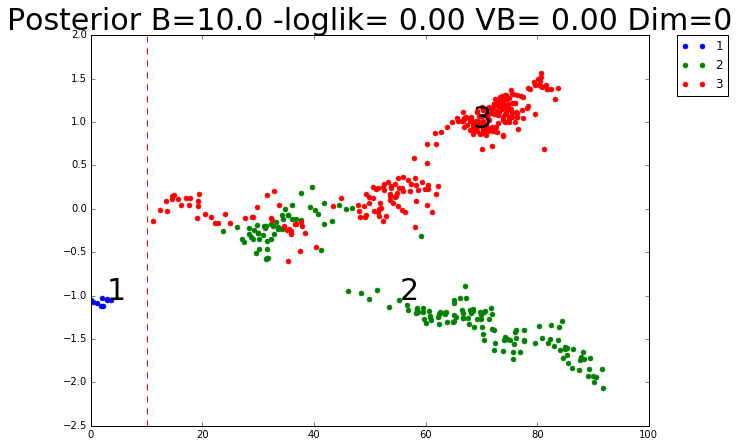

In [9]:
# Plot MAP solution
assigngp_dense.PlotSample(D,m.XExpanded[bestAssignment, : ],3,Y,Bcrap,lw=5.,fs=30, \
                      mV=None, figsizeIn=(D*10,D*7),title='Posterior B=%.1f -loglik= %.2f VB= %.2f'%(b,0,0))

In [49]:
strSaveState = 'InitialAllocationForMAPv1'
saveDict = {'XExpanded':m.XExpanded, 'bestAssignment':bestAssignment, \
            'b':m.kern.branchkernelparam.Bv._array[0], 'pt':pt, 'YGPLVM':m.Y, \
            'lenscale':m.kern.branchkernelparam.kern.lengthscales._array[0],\
            'var':m.kern.branchkernelparam.kern.variance._array[0],\
            'wvar':m.kern.white.variance._array[0],\
            'lvar':m.likelihood.variance._array[0],\
            'indices':m.indices\
           }
pickle.dump( saveDict, open( 'modelfiles/'+strSaveState + '.p', "wb" ) )


In [51]:
len(m.indices)

437

In [20]:
np.save('modelfiles/'+strSaveState + '_MAPmodel',mV.get_free_state())

In [21]:
mR,mVR = mouseQPCRModelSelection.InitModels(pt,m.Y)
mVR

Branching kernel =====================
unnamed.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
unnamed.branchkernelparam.\u001bBv\u001b transform:(none) prior:None
[[ 1.]]
unnamed.white.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
Initialise models: MAP =====================
model.likelihood.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.\u001bvariance\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.kern.\u001blengthscales\u001b transform:+ve prior:None
[ 1.]
model.kern.branchkernelparam.\u001bBv\u001b transform:(none) prior:None
[[ 1.]]
model.kern.white.\u001bvariance\u001b transform:+ve prior:None [FIXED]
[  1.00000000e-06]

Initialise models: VB =====================
compiling tensorflow function...
done


Name,values,prior,constriant
model.likelihood.variance,[ 1.],None,+ve
model.logPhi,"[[-1.05736586 -1.3987364 0.37987387 ..., -0.07820343 -0.72787558 -0.60127001] [ 1.14093849 0.29500095 0.70221183 ..., 0.29103354 1.43405756 -0.1955219 ] [ 0.30029587 1.76308073 -0.12391201 ..., -0.72510635 -1.50151577 0.42550452] ..., [ 0.2350487 -1.84960793 -0.60559056 ..., 0.33339967 -0.10534232 -1.68051316] [ 0.69461243 0.8742174 -2.27753779 ..., 1.18985911 -0.17232812 -0.50919587] [-0.49432404 -0.49161743 1.44999002 ..., 0.24177948 -0.1110826 0.62888568]]",None,(none)
model.kern.branchkernelparam.Bv,[[ 1.]],None,(none)
model.kern.branchkernelparam.kern.variance,[ 1.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 1.],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]


In [22]:
mVR.set_state(np.load('modelfiles/'+strSaveState + '_MAPmodel.npy'))

572911

In [23]:
mVR

Name,values,prior,constriant
model.likelihood.variance,[ 2.39211914],None,+ve
model.logPhi,"[[-0.34806546 0.48131663 -0.57647687 ..., -0.18302217 -0.71324472 0.78212789] [-0.29951576 -2.01645389 0.96263481 ..., 1.43732503 -1.59874586 -0.79011272] [ 2.12006621 -0.36089413 1.40332194 ..., 0.2496119 0.00911477 -1.15760033] ..., [ 1.16311741 0.38008261 0.1299237 ..., -1.08928925 0.44515832 -1.32021196] [ 0.2225133 0.02681855 0.8821404 ..., -1.34829078 0.11240138 1.25994112] [ 0.55911706 0.70526019 0.84547667 ..., 0.4250054 -0.62468447 -2.48546199]]",None,(none)
model.kern.branchkernelparam.Bv,[[ 10.]],None,(none)
model.kern.branchkernelparam.kern.variance,[ 1.],None,+ve
model.kern.branchkernelparam.kern.lengthscales,[ 1.],None,+ve
model.kern.white.variance,[ 1.00000000e-06],None,[FIXED]


In [57]:
l = pt.min() + 1
u = pt.max() - 1
nb = 10
bs=np.linspace(l, u, nb-2)


In [60]:
type(bs[2])

numpy.float64